In [4]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## Week 9: Artificial neural networks

### Perceptron

In the late 1950s, Frank Rosenblatt proposed the perceptron, an algorithm for pattern classification loosely inspired by biological neurons. The perceptron consists of a set of input units that are connected to an output unit. The output unit takes a linear weighted sum of the inputs and passes the sum through a stepwise activation function. Importantly, the perceptron's weights are trainable. This feature provides the perceptron with the ability to learn input-output mappings, constituting a major advance compared to the earlier McCulloch-Pitts neuron model.

The perceptron function is defined by the equation:

$$
f(x)= \begin{cases}1 & \text { if } w \cdot x+b>0 \\ 0 & \text { otherwise }\end{cases}
$$

where $x$ is the input vector, $w$ are the weights connecting the input units to the output unit, and $b$ is the bias term.
$w \cdot x$ is the dot product:

$$
\sum_{i=1}^n w_i x_i
$$

where $n$ is the number of inputs into the perceptron.

### Predict outputs using a pretrained perceptron

We will use the perceptron to classify inputs into two categories. Let our categories be ripe and unripe apples. Each apple is described by two values: colour $x_1$ and size $x_2$. Values on the colour dimension range from green (low) to red (high). Values on the size dimension range from small (low) to large (high). Unripe apples have low values on both dimensions; ripe apples have high values on both dimensions. Let's examine how well a pretrained perceptron can classify apples as ripe or unripe.

### Getting started

In [5]:
# import libraries
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import numpy.matlib
from IPython.display import clear_output

In [6]:
# perceptron function definitions

# generate data for 2 classes (input x and output f(x))
def generate_data(means, sigma, ndatapoints):
    "Create synthetic data for two classes, 0 and 1. Normally distributed."

    nclasses = 2 # do the data generation for two classes
    data = np.zeros((nclasses * ndatapoints, 3))

    for c in range(0, nclasses):

        # get the starting and ending indices for the current class
        starti = c * ndatapoints
        endi = (c + 1) * ndatapoints

        # generate data for the current class
        data[starti:endi, 0:2] = means[c] + sigma * random.standard_normal((ndatapoints, 2))

        # set the class label for the current class (0 or 1)
        data[starti:endi, 2] = c

    # randomize the data -- mix the data for the two classes
    randvec = np.random.permutation(nclasses * ndatapoints)
    data = data[randvec,:]

    return data, randvec;

# plot the decision boundary
def plot_boundary(weights):
    """
    Plot the decision boundary for a given set of weights. Visually seperates the two classes.
    """

    b = weights[0]; w1 = weights[1]; w2 = weights[2]
    slope = -(b / w2) / (b / w1)
    y_intercept = -b / w2

    x = np.linspace(0,1,100)
    y = (slope * x) + y_intercept

    ax = plt.gca()
    ax.plot(x, y)

def plot_boundary_train(weights, data_train, colors_train):
    """
    Plots the decision boundary during training for each iteration. (use in Jupyter notebook)
    Also plots the training data.
    """ 
    
    b = weights[0]; w1 = weights[1]; w2 = weights[2]
    slope = -(b / w2) / (b / w1)
    y_intercept = -b / w2
    x = np.linspace(0,1,100)
    y = (slope * x) + y_intercept

    clear_output(wait=True)  # clear previous plot but keep the latest
    plt.figure(1)  # use the same figure for all updates

    # replot the training data
    plt.scatter(data_train[:,0], data_train[:,1], c=colors_train, alpha=0.5)

    plt.plot(x, y)  # Plot new decision boundary
    plt.axis('square')
    plt.xlabel('x1 (0 = green, 1 = red)')
    plt.ylabel('x2 (0 = small, 1 = large)')
    plt.title('training data with decision boundary')
    plt.xlim(-10,10); plt.ylim(-10,10)
    plt.show()
    plt.pause(0.1)

# predict output
def predict(inputs, weights):
    """
    Predicts the output for a given set of inputs and weights. 
    Single forward pass of the perceptron, for a single input / datapoint.
    """

    # linear weighted sum of the inputs (dot product + bias)
    summation = np.dot(inputs, weights[1:]) + weights[0]

    # step activation function
    if summation > 0:
      prediction = 1
    else:
      prediction = 0
    return prediction

# test perceptron
def test(data, weights):
    """
    Tests the perceptron on a given set of data and weights for an entire dataset.
    Performs a forward pass for each datapoint in the dataset and returns the prediction for each.
    """

    # separate the inputs and labels
    inputs_test = data[:,0:2]
    labels = data[:,2]

    # initialize the predictions array
    npredictions = data.shape[0]
    predictions = np.zeros(npredictions)

    # perform a forward pass for each sample in the dataset
    for i in range(0, npredictions):
        predictions[i] = predict(inputs_test[i,:], weights)
    return predictions

### Test a pre-trained perceptron

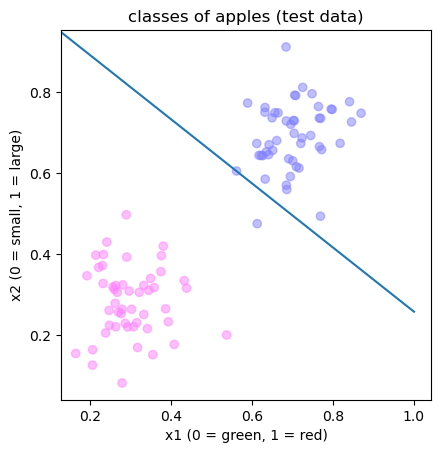

In [7]:
# set parameters for the test data
means = (0.3,0.7)
sigma = 0.08
ndatapoints = 50

# generate test data using the above parameters
data_output_test = generate_data(means, sigma, ndatapoints)
data_test = data_output_test[0]
randvec_test = data_output_test[1]

# pretrained weights (b, w1, w2)
weights = np.array([-0.01261552,  0.00952113,  0.01201932])

# set correct colors for the test data based on the randvec_test
colors_test = np.concatenate((np.matlib.repmat(np.array([1, 0.5, 1]),ndatapoints,1),np.matlib.repmat(np.array([0.5, 0.5, 1]),ndatapoints,1)))
colors_test = colors_test[randvec_test,:]

# show generated data and decision boundary
figi_test = 2; plt.figure(figi_test)
plt.scatter(data_test[:,0], data_test[:,1], c=colors_test, alpha=0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (test data)')
plot_boundary(weights)

# inspect predictions
predictions = test(data_test, weights)
labels_test = data_test[:,2]
errors = labels_test - predictions # nonzero entries indicate errors
nerrors = np.sum(errors**2)

### Train the perceptron

The perceptron's learning rule is defined as follows:

$$
w_i(t+1)=w_i(t)+\alpha(y-\hat{y}(t)) x_i
$$

where $w_i$ is the weight associated with input unit $x_i, t$ is time, $\alpha$ is the learning rate, $y$ is the correct output, and $\hat{y}$ is the output of the perceptron for input vector $x$.

The learning rule is applied to each weight after each input. The bias term is also adjusted after each input, according to the learning rule below. In our Python code, the bias term will be indicated with $w_0$.

$$
b(t+1)=b(t)+\alpha(y-\hat{y}(t))
$$


In [9]:
# function definitions
def train(data, learning_rate, niterations):

    # separate the inputs and labels
    training_inputs = data[:,0:2]
    labels = data[:,2]
    
    # initialize weights (something small and normally distributed)
    weights = 0.001 * random.standard_normal(data.shape[1])

    # initialize errors (track for every sample and every iteration)
    errors = np.zeros((data.shape[0], niterations))

    # do multiple passes over the entire dataset
    j = 0
    for _ in range(niterations):
        i = 0

        # iteration over each sample in the dataset
        for inputs, label in zip(training_inputs, labels):

            # forward pass
            prediction = predict(inputs, weights)

            # update weights and bias
            weights[1:] += learning_rate * (label - prediction) * inputs
            weights[0] += learning_rate * (label - prediction)

            # track errors
            errors[i,j] = label - prediction

            # plot the decision boundary
            plot_boundary_train(weights, data_train, colors_train)
            i += 1

        # update the iteration index
        j += 1

    # return the final weights and errors
    return weights, errors;

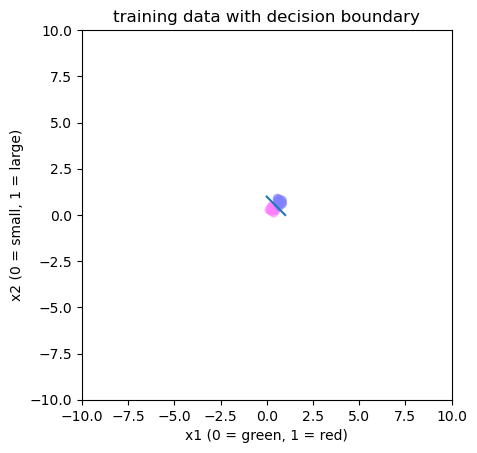

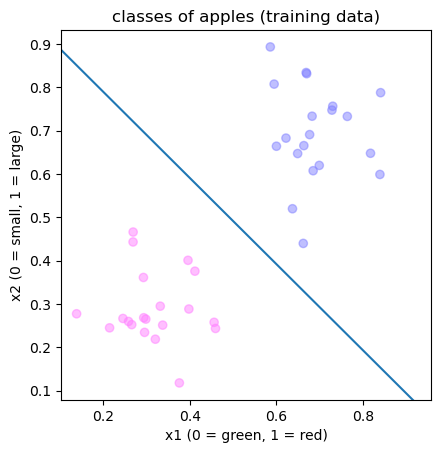

In [10]:
# generate training data
means = (0.3,0.7)
sigma = 0.08
ndatapoints = 20
data_output_train = generate_data(means, sigma, ndatapoints)
data_train = data_output_train[0]
randvec_train = data_output_train[1]

# show generated data
colors_train = np.concatenate((np.matlib.repmat(np.array([1, 0.5, 1]),ndatapoints,1),np.matlib.repmat(np.array([0.5, 0.5, 1]),ndatapoints,1)))
colors_train = colors_train[randvec_train,:]
figi_train = 1; plt.figure(figi_train)
plt.scatter(data_train[:,0], data_train[:,1], c=colors_train, alpha=0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (training data)')

# train perceptron
learning_rate = 0.01
niterations = 2
training_output = train(data_train, learning_rate, niterations)
weights = training_output[0]
errors = training_output[1]
sse = np.sum(errors**2,0)

# plot solution
figi_train = 2; plt.figure(figi_train)
plt.scatter(data_train[:,0], data_train[:,1], c=colors_train, alpha=0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (training data)')
plot_boundary(weights)

Train the perceptron again on the same training data. Do you get the same solution? Play around with different parameters for generating the training data, i.e. change the means and sigma and examine whether the perceptron algorithm converges.

### Test the perceptron

Now test the perceptron that you just trained. The implementation of this step is identical to Predicting outputs using a pretrained perceptron, except that you are now using your 'own' weights.

[0.]


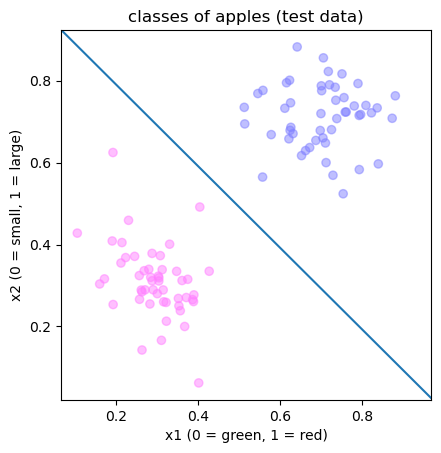

In [50]:
# generate test data
means = (0.3,0.7)
sigma = 0.08
ndatapoints = 50
data_output_test = generate_data(means, sigma, ndatapoints)
data_test = data_output_test[0]
randvec_test = data_output_test[1]

# show generated data and decision boundary
colors_test = np.concatenate((np.matlib.repmat(np.array([1, 0.5, 1]),ndatapoints,1),np.matlib.repmat(np.array([0.5, 0.5, 1]),ndatapoints,1)))
colors_test = colors_test[randvec_test,:]
figi_test = 3; plt.figure(figi_test)
plt.scatter(data_test[:,0], data_test[:,1], c=colors_test, alpha=0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (test data)')
plot_boundary(weights)

# test
predictions = test(data_test, weights)
labels_test = data_test[:,2]
errors = labels_test - predictions # nonzero entries indicate errors
nerrors = np.sum(errors**2)
print(nerrors/labels_test.shape)